In [1]:
import pandas as pd 
import numpy as np 
import sklearn as skl 
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
import time
import warnings
import os
import seaborn as sns # for ploting
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix,f1_score
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt,style
from multiprocessing import Pool

In [2]:
style.use('ggplot')
np.random.seed(42) 

def plot_confusion_matrix(cm, classes,
                          recall,precision,f2,f1,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=90)
    plt.text(12,0, f" Recall:{recall},\n Precision:{precision},\n F2 Score:{f2},\n F1 Score:{f1}", fontsize=12)
    plt.show()

In [3]:
%%markdown
# Loading the data. 

# Loading the data. 


In [6]:
warnings.simplefilter("ignore", category=DeprecationWarning)

root_feature = '/Users/abhijit/Desktop/GIT_Projects/intl-iot/model/features-testing1.1/us'
root_model='/Users/abhijit/Desktop/GIT_Projects/intl-iot/models_final/features-testing1.1/us'

root_output=root_model+'/output'
dir_tsne_plots = root_model + '/tsne-plots'

num_pools=12

In [7]:
%%markdown
## Loading anomaly dataset

## Loading anomaly dataset


In [9]:
anomaly_data = pd.read_csv('/Users/abhijit/Desktop/GIT_Projects/intl-iot/model/testing_data_with_anomaly.csv')
anomaly_data = anomaly_data.drop(anomaly_data.columns[0],axis=1)
anomaly_data.head()

,meanBytes,minBytes,maxBytes,medAbsDev,skewLength,kurtosisLength,q10,q20,q30,q40,...,medianTBP,kurtosisTBP,skewTBP,network_to,network_from,network_both,network_to_external,network_local,anonymous_source_destination,state
0,167.535211,46,1074,35.582453,2.828830,6.599962,46.0,46.0,46.0,58.0,...,0.012187,294.352427,16.653879,284,769,0,0,12,0,android_wan_watch
1,592.564593,62,1484,216.459924,0.575200,-1.602983,66.0,66.0,70.0,144.6,...,0.000085,177.874999,13.135304,0,0,0,209,0,0,anomaly
2,557.774849,46,1074,717.579474,0.006086,-1.864808,46.0,46.0,54.0,102.0,...,0.002305,99.797854,8.426359,287,1029,12,0,0,0,android_lan_watch
3,581.769874,46,1484,216.459924,0.600010,-1.551786,66.0,66.0,66.0,96.4,...,0.000022,82.947470,7.988498,0,0,0,239,0,0,anomaly
4,451.009418,46,1074,38.547658,0.417756,-1.675003,46.0,46.0,46.0,54.0,...,0.003673,71.564209,7.576815,308,846,14,0,0,0,android_lan_watch


In [10]:
anomaly_data.columns

Index(['meanBytes', 'minBytes', 'maxBytes', 'medAbsDev', 'skewLength',
       'kurtosisLength', 'q10', 'q20', 'q30', 'q40', 'q50', 'q60', 'q70',
       'q80', 'q90', 'spanOfGroup', 'meanTBP', 'varTBP', 'medianTBP',
       'kurtosisTBP', 'skewTBP', 'network_to', 'network_from', 'network_both',
       'network_to_external', 'network_local', 'anonymous_source_destination',
       'state'],
      dtype='object')

In [7]:
anomaly_data.state.value_counts()

anomaly                  200
android_wan_watch         48
android_lan_photo         48
android_wan_photo         45
android_lan_recording     36
android_wan_recording     34
android_lan_watch         32
local_move                 4
power                      1
Name: state, dtype: int64

In [8]:
%%markdown

# Loading old model


# Loading old model


In [9]:
original_model = pickle.load(open('/Users/abhijit/Desktop/GIT_Projects/intl-iot/model/tagged-models/us/yi-cameraknn.model','rb'))

In [10]:
labels = []
with open('/Users/abhijit/Desktop/GIT_Projects/intl-iot/model/tagged-models/us/yi-camera.label.txt') as ff:
    for line in ff.readlines():
        line = line.strip()
        if line.startswith('#') or line == '':
            continue
        labels.append(line)

In [11]:
labels

['android_lan_photo',
 'android_lan_recording',
 'android_lan_watch',
 'android_wan_photo',
 'android_wan_recording',
 'android_wan_watch',
 'local_move',
 'power']

In [12]:
di ={}
for i in range(len(labels)):
    di.update({labels[i]:i})

di.update({'anomaly':len(labels)})
print(di)

{'android_lan_photo': 0, 'android_lan_recording': 1, 'android_lan_watch': 2, 'android_wan_photo': 3, 'android_wan_recording': 4, 'android_wan_watch': 5, 'local_move': 6, 'power': 7, 'anomaly': 8}


In [13]:
y_test = anomaly_data['state'].map(di)
y_test.value_counts()

8    200
5     48
0     48
3     45
1     36
4     34
2     32
6      4
7      1
Name: state, dtype: int64

In [14]:
y_test_bin_1d = y_test

In [15]:
ss_knn = original_model['standard_scaler']
pca = original_model['pca']
trained_model = original_model['trained_model']

In [16]:
unknown_data = ss_knn.transform(anomaly_data.drop('state', axis=1))
unknown_data = pca.transform(unknown_data)
unknown_data = pd.DataFrame(unknown_data)
unknown_data = unknown_data.iloc[:, :4]
y_predict = trained_model.predict(unknown_data)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [17]:
y_predict

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0]])

In [18]:
y_predicted_1d = np.argmax(y_predict, axis=1)
set(y_predicted_1d)

{0, 1, 2, 3, 4, 5, 6, 7}

In [19]:
_acc_score = accuracy_score(y_test_bin_1d, y_predicted_1d)
_acc_score

0.5290178571428571

In [20]:
recall = recall_score(y_pred=y_predicted_1d, y_true=y_test_bin_1d,average='weighted')
precision = precision_score(y_pred=y_predicted_1d, y_true=y_test_bin_1d,average='weighted')
f2 = fbeta_score(y_pred=y_predicted_1d, y_true=y_test_bin_1d,average='weighted',beta=2)
f1 = f1_score(y_pred=y_predicted_1d, y_true=y_test_bin_1d,average='weighted')

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
cm = confusion_matrix(y_test_bin_1d, y_predicted_1d)
print(cm)

[[ 45   3   0   0   0   0   0   0   0]
 [  5  31   0   0   0   0   0   0   0]
 [  0   0  32   0   0   0   0   0   0]
 [  2   0   0  43   0   0   0   0   0]
 [  0   0   0   0  34   0   0   0   0]
 [  0   0   0   1   0  47   0   0   0]
 [  0   0   0   0   0   0   4   0   0]
 [  0   0   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0 200   0]]


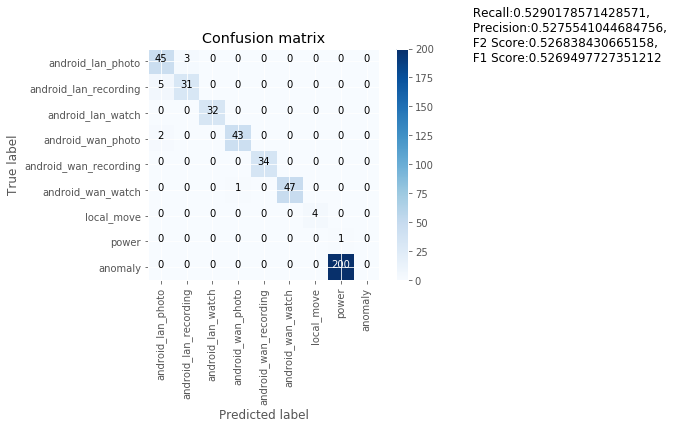

In [22]:
plot_confusion_matrix(cm, classes=list(di.keys()),
                      recall=recall,precision=precision,f2 = f2,f1=f1, title='Confusion matrix')

In [23]:
%%markdown
## Building a combination of the new and the old model. 

## Building a combination of the new and the old model. 


In [24]:
multivariate_model_dict = pickle.load(open('multivariate_model.pkl','rb'))
mv_model = multivariate_model_dict['mvmodel']               
treshold = multivariate_model_dict['treshold']

In [25]:
y_test = anomaly_data['state'].apply(lambda x: 1 if x == 'anomaly' else 0)

In [26]:
anomaly_data.head()

,meanBytes,minBytes,maxBytes,medAbsDev,skewLength,kurtosisLength,q10,q20,q30,q40,...,medianTBP,kurtosisTBP,skewTBP,network_to,network_from,network_both,network_to_external,network_local,anonymous_source_destination,state
0,167.535211,46,1074,35.582453,2.828830,6.599962,46.0,46.0,46.0,58.0,...,0.012187,294.352427,16.653879,284,769,0,0,12,0,android_wan_watch
1,592.564593,62,1484,216.459924,0.575200,-1.602983,66.0,66.0,70.0,144.6,...,0.000085,177.874999,13.135304,0,0,0,209,0,0,anomaly
2,557.774849,46,1074,717.579474,0.006086,-1.864808,46.0,46.0,54.0,102.0,...,0.002305,99.797854,8.426359,287,1029,12,0,0,0,android_lan_watch
3,581.769874,46,1484,216.459924,0.600010,-1.551786,66.0,66.0,66.0,96.4,...,0.000022,82.947470,7.988498,0,0,0,239,0,0,anomaly
4,451.009418,46,1074,38.547658,0.417756,-1.675003,46.0,46.0,46.0,54.0,...,0.003673,71.564209,7.576815,308,846,14,0,0,0,android_lan_watch


In [27]:
y_predict = (mv_model.logpdf(anomaly_data.drop(['state'], axis=1).values) < treshold).astype(int)

In [28]:
y_predict

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,

In [29]:
recall = recall_score(y_pred=y_predict, y_true=y_test,average='weighted')
precision = precision_score(y_pred=y_predict, y_true=y_test,average='weighted')
f2 = fbeta_score(y_pred=y_predict, y_true=y_test,average='weighted',beta=2)
f1 = f1_score(y_pred=y_predict, y_true=y_test,average='weighted')

In [30]:
_acc_score = accuracy_score(y_test, y_predict)
_acc_score

0.984375

In [31]:
cm = confusion_matrix(y_test, y_predict)
print(cm)

[[241   7]
 [  0 200]]


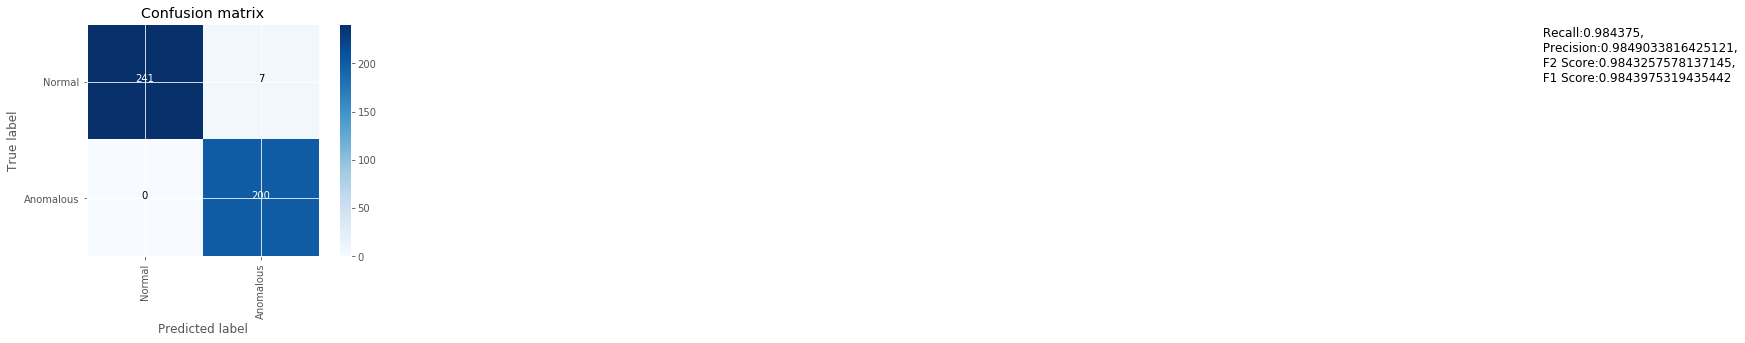

In [32]:
plot_confusion_matrix(cm, classes=['Normal','Anomalous'],
                      recall=recall,precision=precision,f2 = f2,f1=f1, title='Confusion matrix')

In [33]:
new_data = anomaly_data
new_data['anomalous'] = y_predict
normal_data = new_data[new_data['anomalous'] == 0]
anomalous_data = new_data[new_data['anomalous'] == 1]
normal_data.head()

,meanBytes,minBytes,maxBytes,medAbsDev,skewLength,kurtosisLength,q10,q20,q30,q40,...,kurtosisTBP,skewTBP,network_to,network_from,network_both,network_to_external,network_local,anonymous_source_destination,state,anomalous
0,167.535211,46,1074,35.582453,2.828830,6.599962,46.0,46.0,46.0,58.0,...,294.352427,16.653879,284,769,0,0,12,0,android_wan_watch,0
2,557.774849,46,1074,717.579474,0.006086,-1.864808,46.0,46.0,54.0,102.0,...,99.797854,8.426359,287,1029,12,0,0,0,android_lan_watch,0
4,451.009418,46,1074,38.547658,0.417756,-1.675003,46.0,46.0,46.0,54.0,...,71.564209,7.576815,308,846,14,0,0,0,android_lan_watch,0
5,151.687500,46,1074,35.582453,3.256768,9.958463,46.0,46.0,46.0,56.0,...,82.069233,6.932642,465,1034,0,0,5,0,android_wan_recording,0
7,143.101254,46,1074,35.582453,3.383325,10.350989,46.0,46.0,46.0,58.0,...,646.172005,23.207788,307,726,0,0,4,0,android_wan_watch,0


In [34]:
unknown_data = ss_knn.transform(normal_data.drop(['state','anomalous'], axis=1))
unknown_data = pca.transform(unknown_data)
unknown_data = pd.DataFrame(unknown_data)
unknown_data = unknown_data.iloc[:, :4]
y_predict = trained_model.predict(unknown_data)
y_predicted_1d = np.argmax(y_predict, axis=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [35]:
normal_data['predictions'] = y_predicted_1d
anomalous_data['predictions'] = 8

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:
final_data = normal_data.append(anomalous_data).sort_index()

In [37]:
y_test = final_data['state'].map(di)
y_predict = final_data['predictions']

In [38]:
recall = recall_score(y_pred=y_predict, y_true=y_test,average='weighted')
precision = precision_score(y_pred=y_predict, y_true=y_test,average='weighted')
f2 = fbeta_score(y_pred=y_predict, y_true=y_test,average='weighted',beta=2)
f1 = f1_score(y_pred=y_predict, y_true=y_test,average='weighted')

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
_acc_score = accuracy_score(y_test, y_predict)
_acc_score

0.9620535714285714

In [40]:
cm = confusion_matrix(y_test, y_predict)
print(cm)

[[ 44   3   0   0   0   0   0   0   1]
 [  4  31   0   0   0   0   0   0   1]
 [  0   0  32   0   0   0   0   0   0]
 [  2   0   0  43   0   0   0   0   0]
 [  0   0   0   0  34   0   0   0   0]
 [  0   0   0   1   0  47   0   0   0]
 [  0   0   0   0   0   0   0   0   4]
 [  0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0 200]]


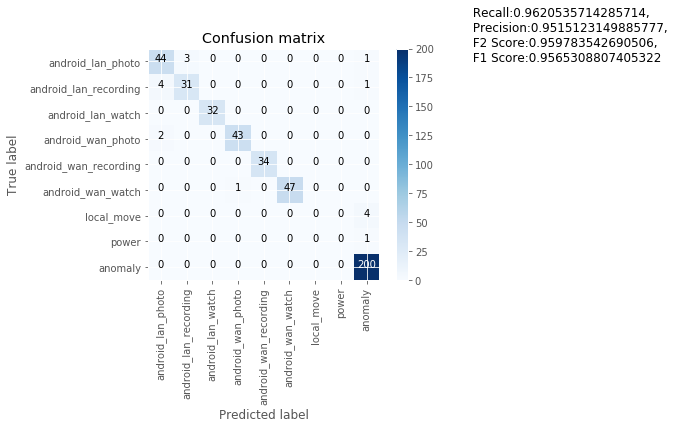

In [41]:
plot_confusion_matrix(cm, classes=list(di.keys()),
                      recall=recall,precision=precision,f2 = f2,f1=f1, title='Confusion matrix')

In [43]:
di['anomaly']

8